# Predict survival on the Titanic (Kaggle)

## Import the data and EDA

In [56]:
import numpy as np
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


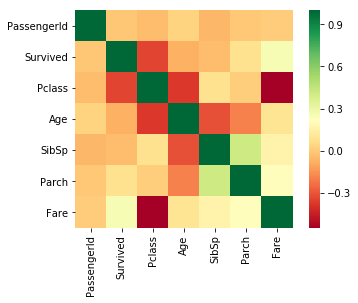

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')
plt.show()

## Preparing X, y

In [46]:
# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[['Sex']] = df[['Sex']].apply(categorize_label, axis=0)

# Print the converted dtypes
print(df[['Sex']].dtypes)

Sex    category
dtype: object


In [63]:
df = pd.read_csv('train.csv')
df_sex = pd.get_dummies(df[['Sex']], drop_first=True)
df_sex.head()

df['Sex_male'] = df_sex
df = df.drop('Sex', axis=1)
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1


In [164]:
X = df[['Pclass','Age','Sex_male','SibSp','Fare', 'Parch']]
y = df['Survived']

## Splitting training and test data

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Building the model
Using Pipeline, we can easily try several models :

In [214]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, PolynomialFeatures
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Edit model step in pipeline
pl = Pipeline([
        ('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)),
        ('int', PolynomialFeatures(degree=3, interaction_only=True)),
        #('clf_cv', RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=5))
        #('logreg_cv', GridSearchCV(LogisticRegression(), param_grid, cv=5))
        #('clf', LogisticRegression())
        #('ridge', Ridge(normalize=True))
        #('clf', LinearRegression())
        ('clf', OneVsRestClassifier(LogisticRegression()))
        #('knn', KNeighborsClassifier(n_neighbors=3))
        #('clf', RandomForestClassifier(n_estimators=20)) # Adjusting parameters
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy: ", accuracy)



Accuracy:  0.813432835821


In [215]:
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(pl, X, y, cv=5))

0.81714718168429035

## Create submission file

In [216]:
df_test = pd.read_csv('test.csv', index_col=0)
df_test.head()

df_test_sex = pd.get_dummies(df_test[['Sex']], drop_first=True)
df_test_sex.head()

df_test['Sex_male'] = df_test_sex
df_test = df_test.drop('Sex', axis=1)
df_test.head()

X_df_test = df_test[X.columns]

predictions = pl.predict(X_df_test)

prediction_df = pd.DataFrame(columns=['Survived'], index=df_test.index, data=predictions)

prediction_df.to_csv("predictions.csv")